In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from tqdm import tqdm
import yfinance

In [2]:
df = yfinance.download (tickers = "GC=F", start = "1985-01-01", interval = "1d")

[*********************100%***********************]  1 of 1 completed


In [4]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-08-30,273.899994,273.899994,273.899994,273.899994,273.899994,0
2000-08-31,274.799988,278.299988,274.799988,278.299988,278.299988,0
2000-09-01,277.000000,277.000000,277.000000,277.000000,277.000000,0
2000-09-05,275.799988,275.799988,275.799988,275.799988,275.799988,2
2000-09-06,274.200012,274.200012,274.200012,274.200012,274.200012,0
...,...,...,...,...,...,...
2023-09-01,1950.000000,1950.000000,1936.599976,1939.800049,1939.800049,167
2023-09-05,1934.400024,1934.400024,1924.699951,1926.199951,1926.199951,113
2023-09-06,1924.099976,1925.300049,1916.300049,1918.099976,1918.099976,24


In [5]:
data = df['Close'].values
lows = df['Low'].values
highs = df['High'].values
data = data[:-1]
lows = lows[:-1]
highs = highs[:-1]

In [6]:
def SMA(n , data , size):
    sma_list = [0] * (n - 1)
    for i in range(n, data.shape[0]+1):
        sma_list.append(np.mean(data[i-n:i]))
    return(sma_list[-1*size:])

In [7]:
def CUTS(sma1 , sma2): # sma1 shorter than sma2
    cut = []
    typ = []
    old = 1
    for i in range(len(sma1)):
        if (sma1[i]>=sma2[i]):
            new = 1
        else:
            new = -1
        if (old != new):
            cut.append(i)
            if (new==-1) :
                typ.append(-1)
            else:
                typ.append(1)
        old = new
    result = np.array([cut , typ])
    return result

In [8]:
def PROFITS (pdata, ldata , cuts , tcost):
    profit = []
    maxdraw = []
    for i in range (cuts.shape[1]):
        if (cuts[1,i]==1) &(i<cuts.shape[1]-1):
            trade = (pdata[cuts[0,i+1]] - pdata[cuts[0,i]])/pdata[cuts[0,i]]
            realprof = (1-tcost)*(1-tcost)*(1+trade) - 1
            profit.append(realprof)
            maxdrawpoint = cuts[0,i] + np.argmin(ldata[cuts[0,i] : cuts[0,i+1]+1])
            draw = (ldata[maxdrawpoint] - pdata[cuts[0,i]])/pdata[cuts[0,i]]
            realdraw = (1-tcost)*(1-tcost)*(1+draw) - 1
            maxdraw.append(realdraw)
    return profit , maxdraw

In [10]:
N = 5000
smas = np.zeros((1000 , N) , dtype = float)
for i in tqdm(range (smas.shape[0])):
    smas [i , :] = SMA(i+1 , data , N)

100%|███████████████████████████████████████| 1000/1000 [00:14<00:00, 68.54it/s]


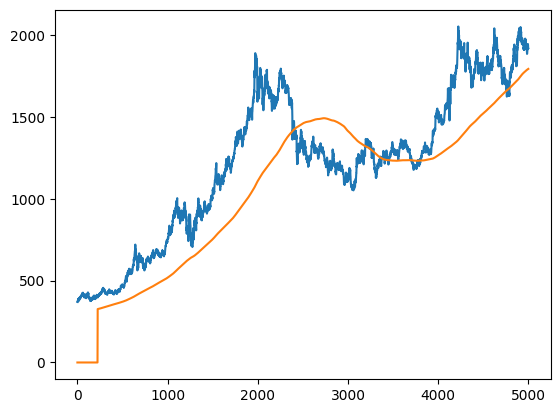

In [11]:
plt.plot(data[-N:])
plt.plot(smas[999,:])

In [12]:
cuts = CUTS(smas[30,:] , smas[35,:])

In [13]:
profits , maxdraws = PROFITS(data[-1*N:] , lows[-1*N:] , cuts , 0.01)

/var/folders/cy/s7_pzg4x2xxcg7cty448hrxc0000gn/T/ipykernel_12319/3217440611.py:7: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if (cuts[1,np.where(cuts[0,:]==i)[0]]==1):


(20000.0, 35000.0)

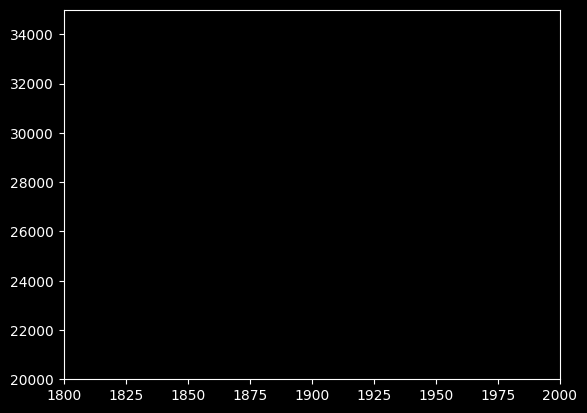

In [14]:
d = data[-N:]
t = np.linspace(0 , N , num = N)
buys = np.zeros(N)
sells = np.zeros(N)
for i in range(N):
    if i in cuts:
        if (cuts[1,np.where(cuts[0,:]==i)[0]]==1):
            buys[i]= d[i]
        else:
            sells[i] = d[i]
plt.style.use('dark_background')
plt.plot(data[-N:] , color = 'white')
plt.plot(smas[30 , :] , color = 'blue')
plt.plot(smas[35 , :] , color = 'yellow')
plt.plot(t , buys , 'o' , color = 'green' , markersize = 5)
plt.plot(t , sells , 'o' , color = 'red' , markersize = 5)
plt.xlim(1800,2000)
plt.ylim(20000,35000)

In [15]:
allprofits = np.zeros((smas.shape[0],smas.shape[0],N))
alldraws = np.zeros((smas.shape[0],smas.shape[0],N))
sls = np.linspace(0,1,101)
overalls = np.zeros((smas.shape[0],smas.shape[0] , len(sls)))
for i in tqdm(range(smas.shape[0])):
    for j in range (i+1 , smas.shape[0]):
        cuts = CUTS(smas[i,:] , smas[j,:])
        profits , maxdraws = PROFITS(data[-1*N:] , lows[-1*N:] , cuts , 0.01)
        allprofits[i,j,0:len(profits)] = profits
        allprofits[j,i,0:len(profits)] = profits
        alldraws[i,j,0:len(maxdraws)] = maxdraws
        alldraws[j,i,0:len(maxdraws)] = maxdraws
        for k in range (len(sls)):
            sl = sls[k]
            multis = 1+np.array(profits)
            overalls[i,j,k] = np.prod(multis[np.array(maxdraws)>-sl])*(1-sl)**(multis[np.array(maxdraws)<=-sl].shape[0])
            overalls[j,i,k] = overalls[i,j,k]

100%|███████████████████████████████████████| 1000/1000 [10:01<00:00,  1.66it/s]


In [16]:
bsls = np.max(overalls , axis = 2)

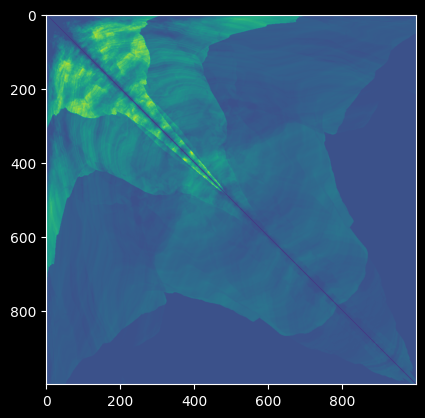

In [17]:
plt.imshow(bsls)

In [18]:
maxsma1 , maxsma2 , sl = np.unravel_index(np.argmax(overalls), overalls.shape)

In [19]:
maxsma1

372

In [20]:
maxsma2

394

In [21]:
sl

19

In [22]:
sls[15]

0.15

In [23]:
overalls[75,675,15]

1.1203278649192285

In [24]:
np.max(overalls)

4.053129976431458

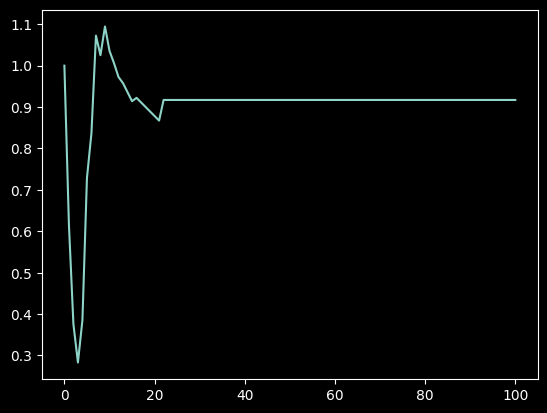

In [25]:
plt.plot(overalls[20,60,:])

In [26]:
np.max(overalls[30,35,:])

1.0

In [27]:
data[-2000]

1131.5999755859375